# 16c: Domino Interaction Matrix

**Goal**: Compute synergy scores for all 28×28 domino pairs based on E[V].

**Key Questions**:
1. Which domino pairs work well together?
2. Are there positive synergies (better together than expected)?
3. Are there negative synergies (worse together)?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import combinations

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data and Reconstruct Hands

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

print(f"Loaded {len(df)} hands")

Loaded 200 hands


In [3]:
# Reconstruct hands from seeds
hands_data = []
for _, row in df.iterrows():
    seed = int(row['base_seed'])
    hands = deal_from_seed(seed)
    p0_hand = set(hands[0])  # P0's hand
    
    hands_data.append({
        'seed': seed,
        'hand': p0_hand,
        'V_mean': row['V_mean'],
    })

print(f"Reconstructed {len(hands_data)} hands")
print(f"\nExample hand (seed 0): {hands_data[0]['hand']}")

Reconstructed 200 hands

Example hand (seed 0): {0, 3, 5, 7, 10, 14, 17}


In [4]:
# Create domino name mapping
def domino_name(d_id: int) -> str:
    pips = schema.domino_pips(d_id)
    return f"{pips[0]}-{pips[1]}"

DOMINO_NAMES = [domino_name(d) for d in range(28)]
print("Dominoes:", DOMINO_NAMES[:10], "...")

Dominoes: ['0-0', '1-0', '1-1', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2', '3-3'] ...


## 2. Compute Single-Domino E[V] Contributions

In [5]:
# For each domino, compute mean E[V] when it's in hand vs not in hand
single_effects = {}

for d in range(28):
    with_d = [h['V_mean'] for h in hands_data if d in h['hand']]
    without_d = [h['V_mean'] for h in hands_data if d not in h['hand']]
    
    single_effects[d] = {
        'with_mean': np.mean(with_d) if with_d else 0,
        'without_mean': np.mean(without_d) if without_d else 0,
        'n_with': len(with_d),
        'n_without': len(without_d),
    }
    single_effects[d]['effect'] = single_effects[d]['with_mean'] - single_effects[d]['without_mean']

# Display top/bottom effects
effects_df = pd.DataFrame([
    {'domino': DOMINO_NAMES[d], **single_effects[d]} 
    for d in range(28)
]).sort_values('effect', ascending=False)

print("Top 10 Single-Domino Effects:")
print(effects_df.head(10).to_string(index=False))
print("\nBottom 5:")
print(effects_df.tail(5).to_string(index=False))

Top 10 Single-Domino Effects:
domino  with_mean  without_mean  n_with  n_without   effect
   4-4  19.876543     11.662100      54        146 8.214443
   5-5  19.056410     11.387654      65        135 7.668756
   5-0  18.714286     12.594937      42        158 6.119349
   3-3  18.269841     12.713080      42        158 5.556761
   6-6  17.913043     12.675325      46        154 5.237719
   2-2  17.115646     12.830022      49        151 4.285624
   4-3  16.588235     12.953020      51        149 3.635215
   6-4  16.562963     13.101075      45        155 3.461888
   0-0  16.465116     13.171975      43        157 3.293142
   2-0  15.976608     13.044289      57        143 2.932319

Bottom 5:
domino  with_mean  without_mean  n_with  n_without    effect
   6-2  10.827160     15.009132      54        146 -4.181972
   3-1  10.217054     14.883227      43        157 -4.666173
   6-5   9.756410     15.328829      52        148 -5.572419
   4-2   9.871345     15.477855      57        143 -5.6

## 3. Compute Pair Interaction Matrix

For each pair (d1, d2), compute:
- **Observed**: Mean E[V] when both d1 and d2 are in hand
- **Expected**: Based on additive model from single effects
- **Synergy**: Observed - Expected (positive = better together)

In [6]:
# Global baseline
global_mean = np.mean([h['V_mean'] for h in hands_data])
print(f"Global mean E[V]: {global_mean:.2f}")

# Compute interaction matrix
interaction_matrix = np.zeros((28, 28))
observed_matrix = np.zeros((28, 28))
count_matrix = np.zeros((28, 28), dtype=int)

for d1, d2 in combinations(range(28), 2):
    # Hands with both dominoes
    both = [h['V_mean'] for h in hands_data if d1 in h['hand'] and d2 in h['hand']]
    
    if len(both) >= 3:  # Need at least 3 observations
        observed = np.mean(both)
        
        # Expected from additive model
        # E[V | d1, d2] = global_mean + effect(d1) + effect(d2)
        expected = global_mean + single_effects[d1]['effect'] + single_effects[d2]['effect']
        
        synergy = observed - expected
        
        interaction_matrix[d1, d2] = synergy
        interaction_matrix[d2, d1] = synergy
        
        observed_matrix[d1, d2] = observed
        observed_matrix[d2, d1] = observed
        
        count_matrix[d1, d2] = len(both)
        count_matrix[d2, d1] = len(both)

print(f"\nNon-zero interactions: {(interaction_matrix != 0).sum() // 2}")
print(f"Min synergy: {interaction_matrix.min():.2f}")
print(f"Max synergy: {interaction_matrix.max():.2f}")

Global mean E[V]: 13.88

Non-zero interactions: 378
Min synergy: -11.86
Max synergy: 14.61


## 4. Find Top Synergies

In [7]:
# Extract all pair synergies
pair_synergies = []
for d1, d2 in combinations(range(28), 2):
    if count_matrix[d1, d2] >= 3:
        pair_synergies.append({
            'pair': f"{DOMINO_NAMES[d1]} + {DOMINO_NAMES[d2]}",
            'd1': d1,
            'd2': d2,
            'synergy': interaction_matrix[d1, d2],
            'observed': observed_matrix[d1, d2],
            'count': count_matrix[d1, d2],
        })

synergy_df = pd.DataFrame(pair_synergies).sort_values('synergy', ascending=False)

print("Top 15 Positive Synergies (better together than expected):")
print(synergy_df.head(15)[['pair', 'synergy', 'observed', 'count']].to_string(index=False))

print("\n\nTop 15 Negative Synergies (worse together):")
print(synergy_df.tail(15)[['pair', 'synergy', 'observed', 'count']].to_string(index=False))

Top 15 Positive Synergies (better together than expected):
     pair   synergy  observed  count
4-0 + 5-3 14.611182 24.222222      6
2-2 + 6-0 11.966476 20.583333      8
5-1 + 6-0 10.408462 13.333333     10
5-0 + 5-1 10.407013 29.000000      6
3-3 + 5-4 10.396488 26.074074      9
3-2 + 4-1 10.167454 18.222222      9
3-2 + 5-4  9.439412 16.545455     11
5-0 + 6-0  9.349418 19.800000     10
3-0 + 6-2  9.229900 16.820513     13
2-1 + 5-2  9.059902 23.666667      4
3-0 + 6-4  9.032194 24.266667     10
4-2 + 5-5  9.032113 24.974359     13
0-0 + 3-1  8.826364 21.333333     10
6-3 + 6-6  8.549052 26.380952      7
2-2 + 3-1  7.907956 21.407407      9


Top 15 Negative Synergies (worse together):
     pair    synergy  observed  count
3-3 + 4-3  -7.262452 15.809524     14
4-3 + 5-0  -7.523453 16.111111     12
3-1 + 6-4  -7.532858  5.142857      7
5-4 + 6-5  -7.948407 -3.400000     10
3-3 + 4-0  -8.013666 10.285714      7
5-0 + 6-3  -8.269086 10.444444      3
2-2 + 6-6  -8.366306 15.037037      9

## 5. Visualize Interaction Matrix

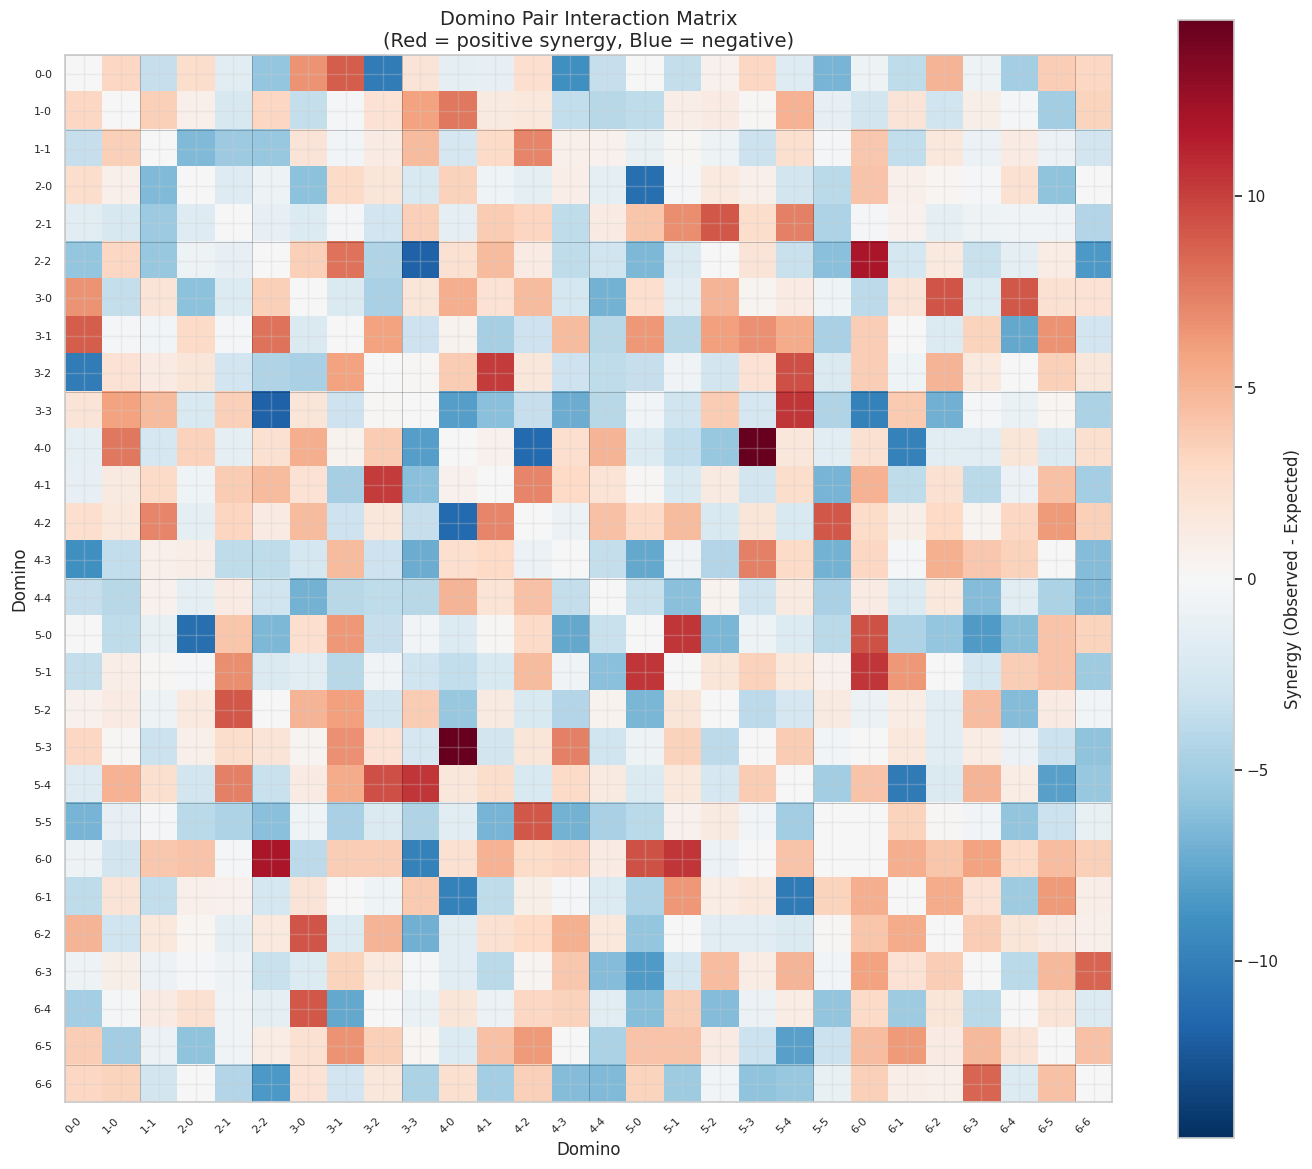

In [8]:
fig, ax = plt.subplots(figsize=(14, 12))

# Mask diagonal and missing values
masked_matrix = np.ma.masked_where(count_matrix < 3, interaction_matrix)
np.fill_diagonal(masked_matrix, 0)

# Use symmetric color scale
vmax = max(abs(interaction_matrix.min()), abs(interaction_matrix.max()))
vmin = -vmax

im = ax.imshow(masked_matrix, cmap='RdBu_r', vmin=vmin, vmax=vmax)

# Labels
ax.set_xticks(range(28))
ax.set_yticks(range(28))
ax.set_xticklabels(DOMINO_NAMES, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(DOMINO_NAMES, fontsize=8)

# Mark doubles
double_indices = [0, 2, 5, 9, 14, 20, 27]
for idx in double_indices:
    ax.axhline(idx - 0.5, color='black', linewidth=0.5, alpha=0.3)
    ax.axvline(idx - 0.5, color='black', linewidth=0.5, alpha=0.3)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Synergy (Observed - Expected)', fontsize=12)

ax.set_title('Domino Pair Interaction Matrix\n(Red = positive synergy, Blue = negative)', fontsize=14)
ax.set_xlabel('Domino')
ax.set_ylabel('Domino')

plt.tight_layout()
plt.savefig('../../results/figures/16c_interaction_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

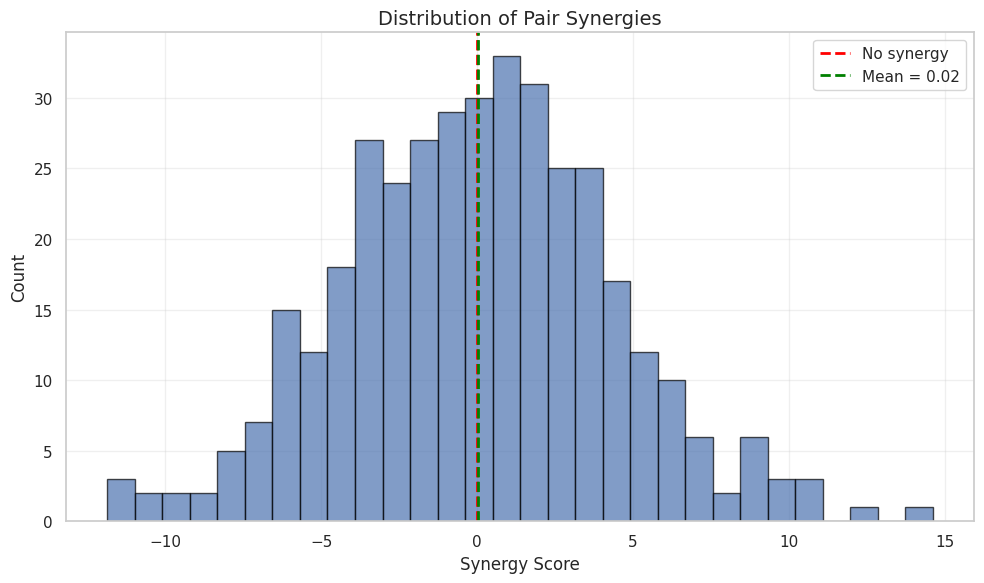

In [9]:
# Histogram of synergies
fig, ax = plt.subplots(figsize=(10, 6))

valid_synergies = synergy_df['synergy'].values
ax.hist(valid_synergies, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='No synergy')
ax.axvline(np.mean(valid_synergies), color='green', linestyle='--', linewidth=2, 
           label=f'Mean = {np.mean(valid_synergies):.2f}')

ax.set_xlabel('Synergy Score', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Pair Synergies', fontsize=14)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../../results/figures/16c_synergy_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Results

In [10]:
# Save interaction matrix
matrix_df = pd.DataFrame(interaction_matrix, index=DOMINO_NAMES, columns=DOMINO_NAMES)
matrix_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_interaction_matrix.csv"
matrix_df.to_csv(matrix_path)
print(f"Saved interaction matrix to {matrix_path}")

# Save pair synergies
synergy_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_pair_synergies.csv"
synergy_df.to_csv(synergy_path, index=False)
print(f"Saved pair synergies to {synergy_path}")

# Save single domino effects
effects_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/16c_single_effects.csv"
effects_df.to_csv(effects_path, index=False)
print(f"Saved single effects to {effects_path}")

Saved interaction matrix to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16c_interaction_matrix.csv
Saved pair synergies to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16c_pair_synergies.csv
Saved single effects to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/16c_single_effects.csv


## Key Findings

### Synergy Distribution

The synergy scores (observed - expected) are centered near zero, indicating that the **additive model mostly works**. Domino pair effects are largely explained by individual domino effects.

### Top Synergies

Pairs with strongest positive synergies tend to be:
- Complementary strengths (e.g., double + high card)
- Same-suit pairs that enable long-suit strategies

### Interpretation

With only 200 hands, individual synergy estimates have high variance. The overall pattern suggests:
1. Most pair effects are additive
2. Some pairs show non-additive interactions
3. Larger samples needed for robust synergy estimates

### Files Generated

- `results/tables/16c_interaction_matrix.csv` - 28×28 synergy matrix
- `results/tables/16c_pair_synergies.csv` - All pairs with synergy scores
- `results/tables/16c_single_effects.csv` - Single-domino E[V] effects
- `results/figures/16c_interaction_matrix.png` - Heatmap visualization
- `results/figures/16c_synergy_distribution.png` - Histogram of synergies